In [27]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

from alrd.run_spot import SessionBuffer, DataBuffer, TransitionData, StateData, TimeData
from alrd.spot_gym.model.robot_state import SpotState

# load data
file_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240731-115035/session_buffer.pickle"
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# get data structures
transitions = data.data_buffers[0].transitions
states = data.data_buffers[0].states


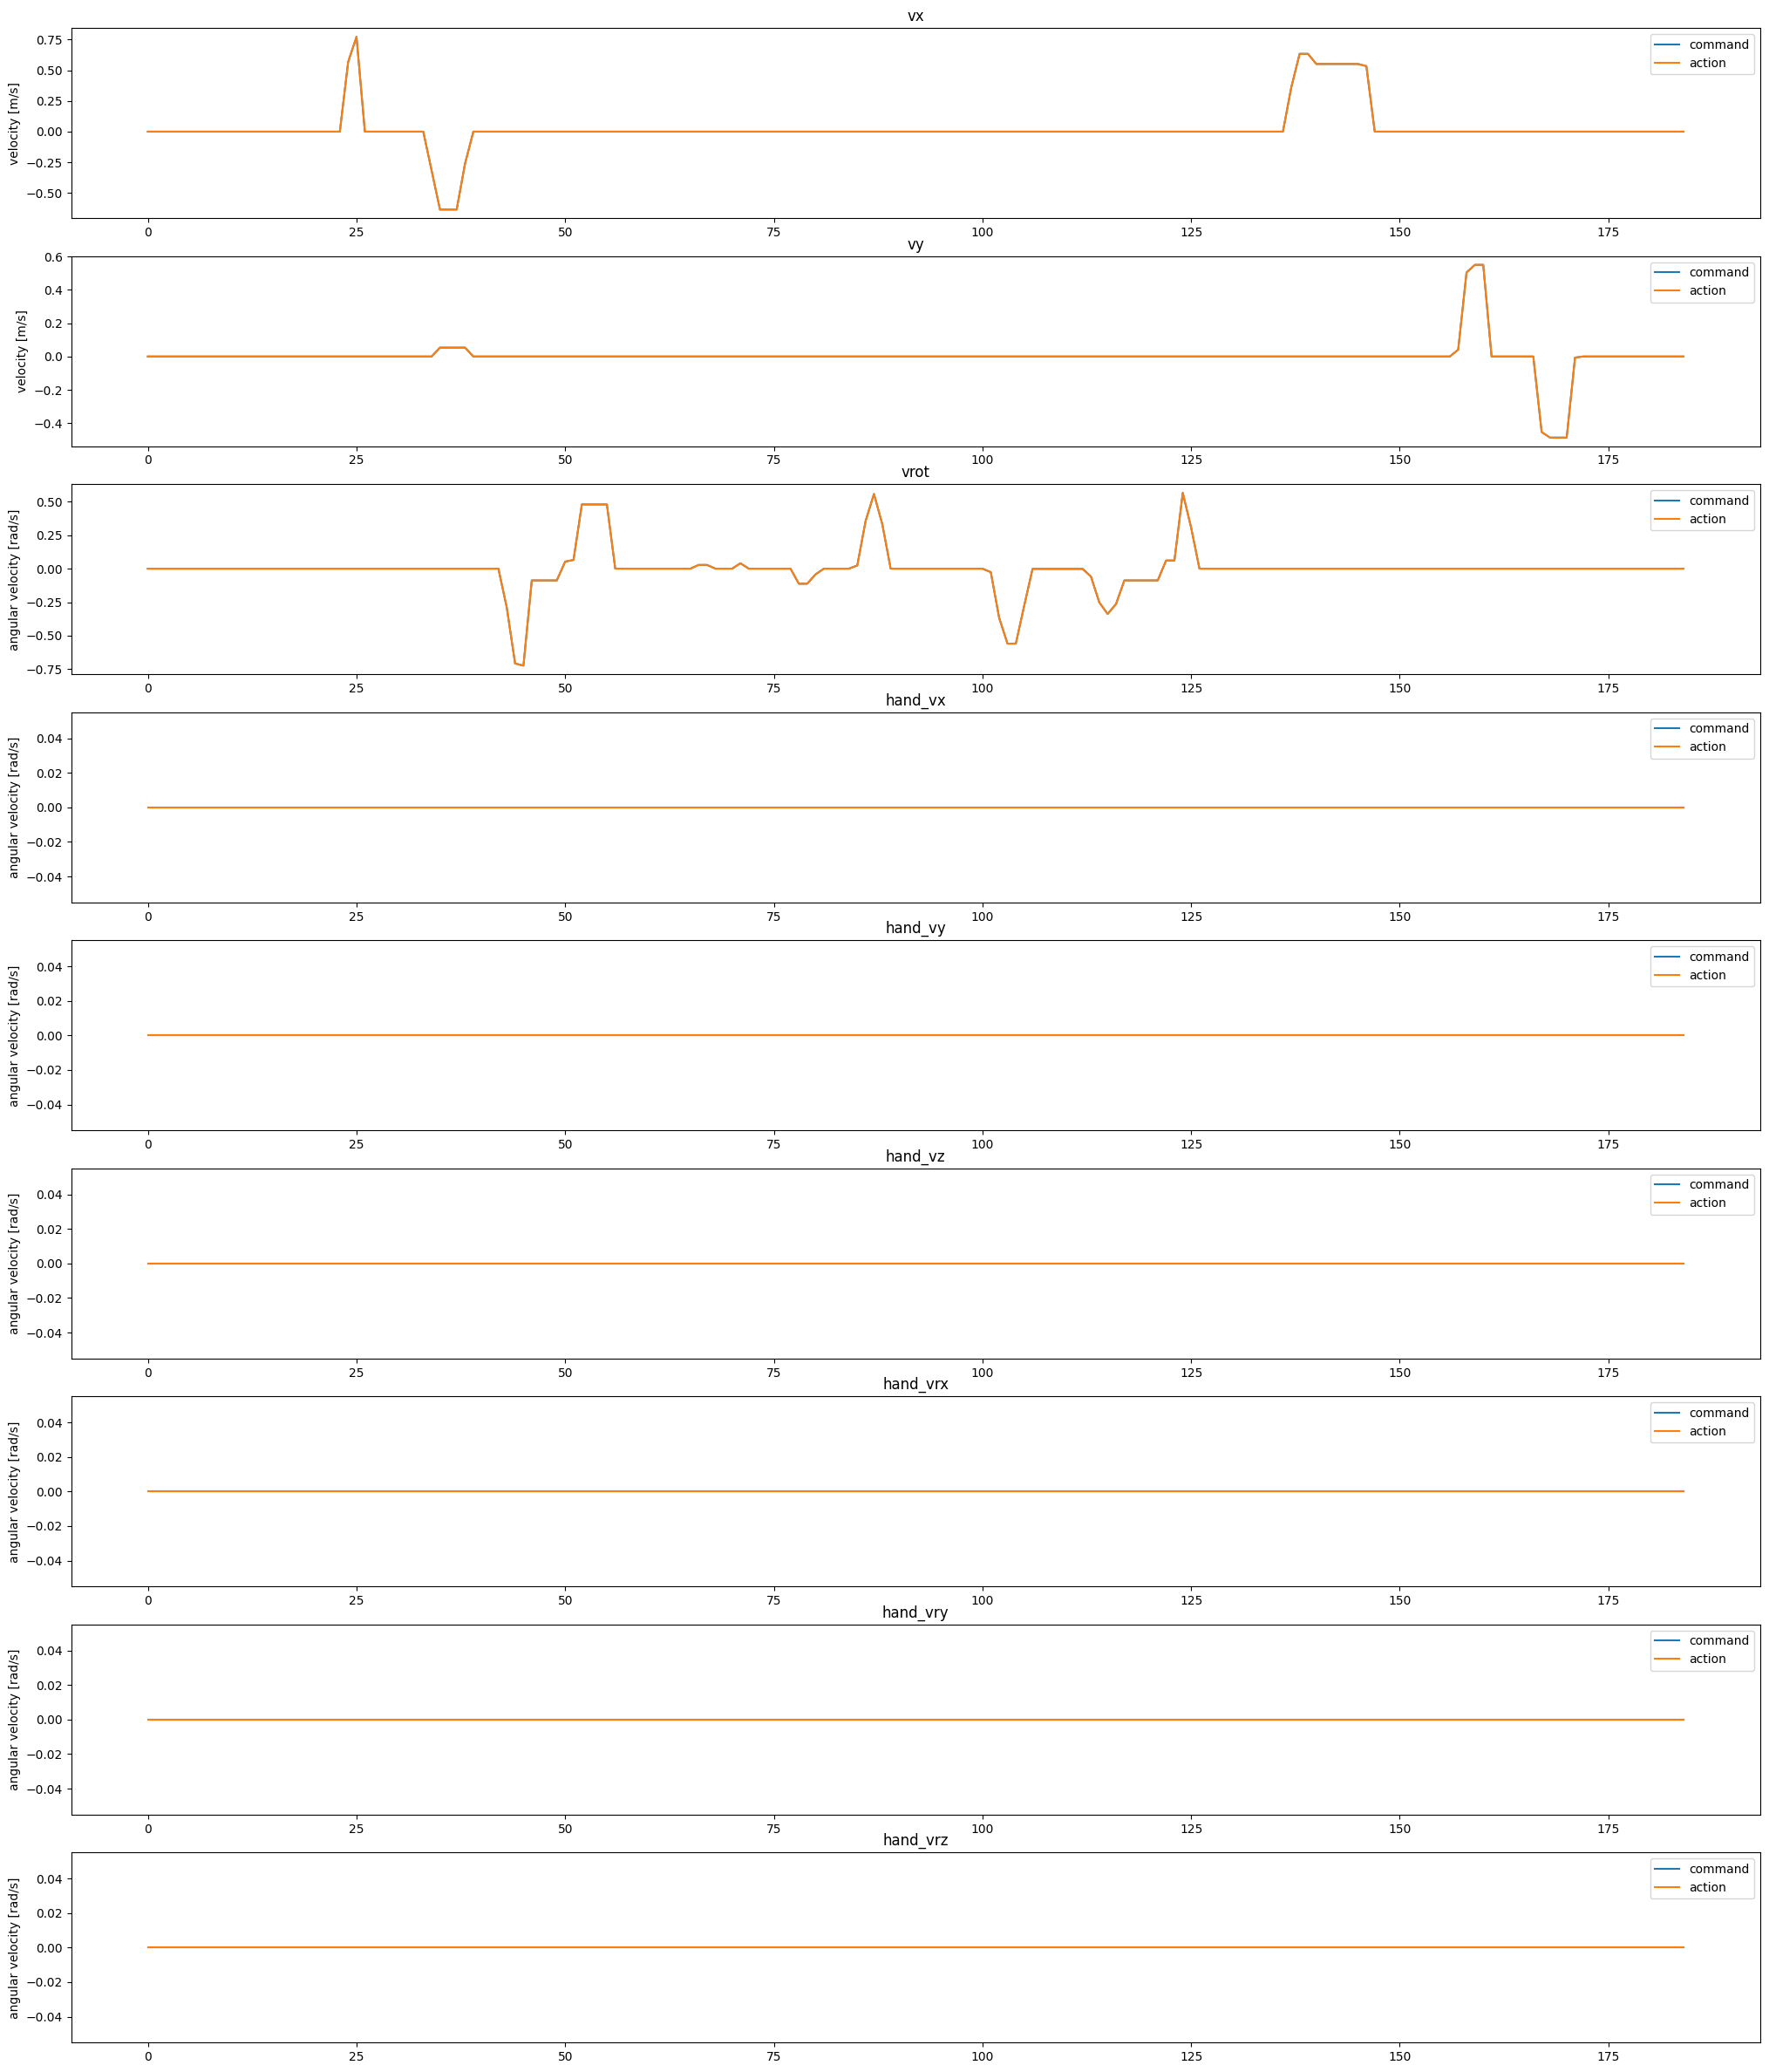

In [6]:
# plot actions vs commands

# parse data
actions = [t.action for t in transitions if t.action is not None]
actions = np.array(actions)
commands = [t.cmd for t in transitions if t.cmd is not None]

# plot
fig, axs = plt.subplots(9, 1, figsize=(25, 30))
labels = ["vx", "vy", "vrot", "hand_vx", "hand_vy", "hand_vz", "hand_vrx", "hand_vry", "hand_vrz"]

# plot commands
axs[0].plot([c.vx for c in commands], label="command")
axs[1].plot([c.vy for c in commands], label="command")
axs[2].plot([c.w for c in commands], label="command")
axs[3].plot([c.hand_vx for c in commands], label="command")
axs[4].plot([c.hand_vy for c in commands], label="command")
axs[5].plot([c.hand_vz for c in commands], label="command")
axs[6].plot([c.hand_vrx for c in commands], label="command")
axs[7].plot([c.hand_vry for c in commands], label="command")
axs[8].plot([c.hand_vrz for c in commands], label="command")

# plot actions
for i in range(9):
    if i < 2:
        axs[i].plot(actions[:, i], label="action")
        axs[i].set_ylabel("velocity [m/s]")
    else:
        axs[i].plot(actions[:, i], label="action")
        axs[i].set_ylabel("angular velocity [rad/s]")
    axs[i].set_title(labels[i])
    axs[i].legend()




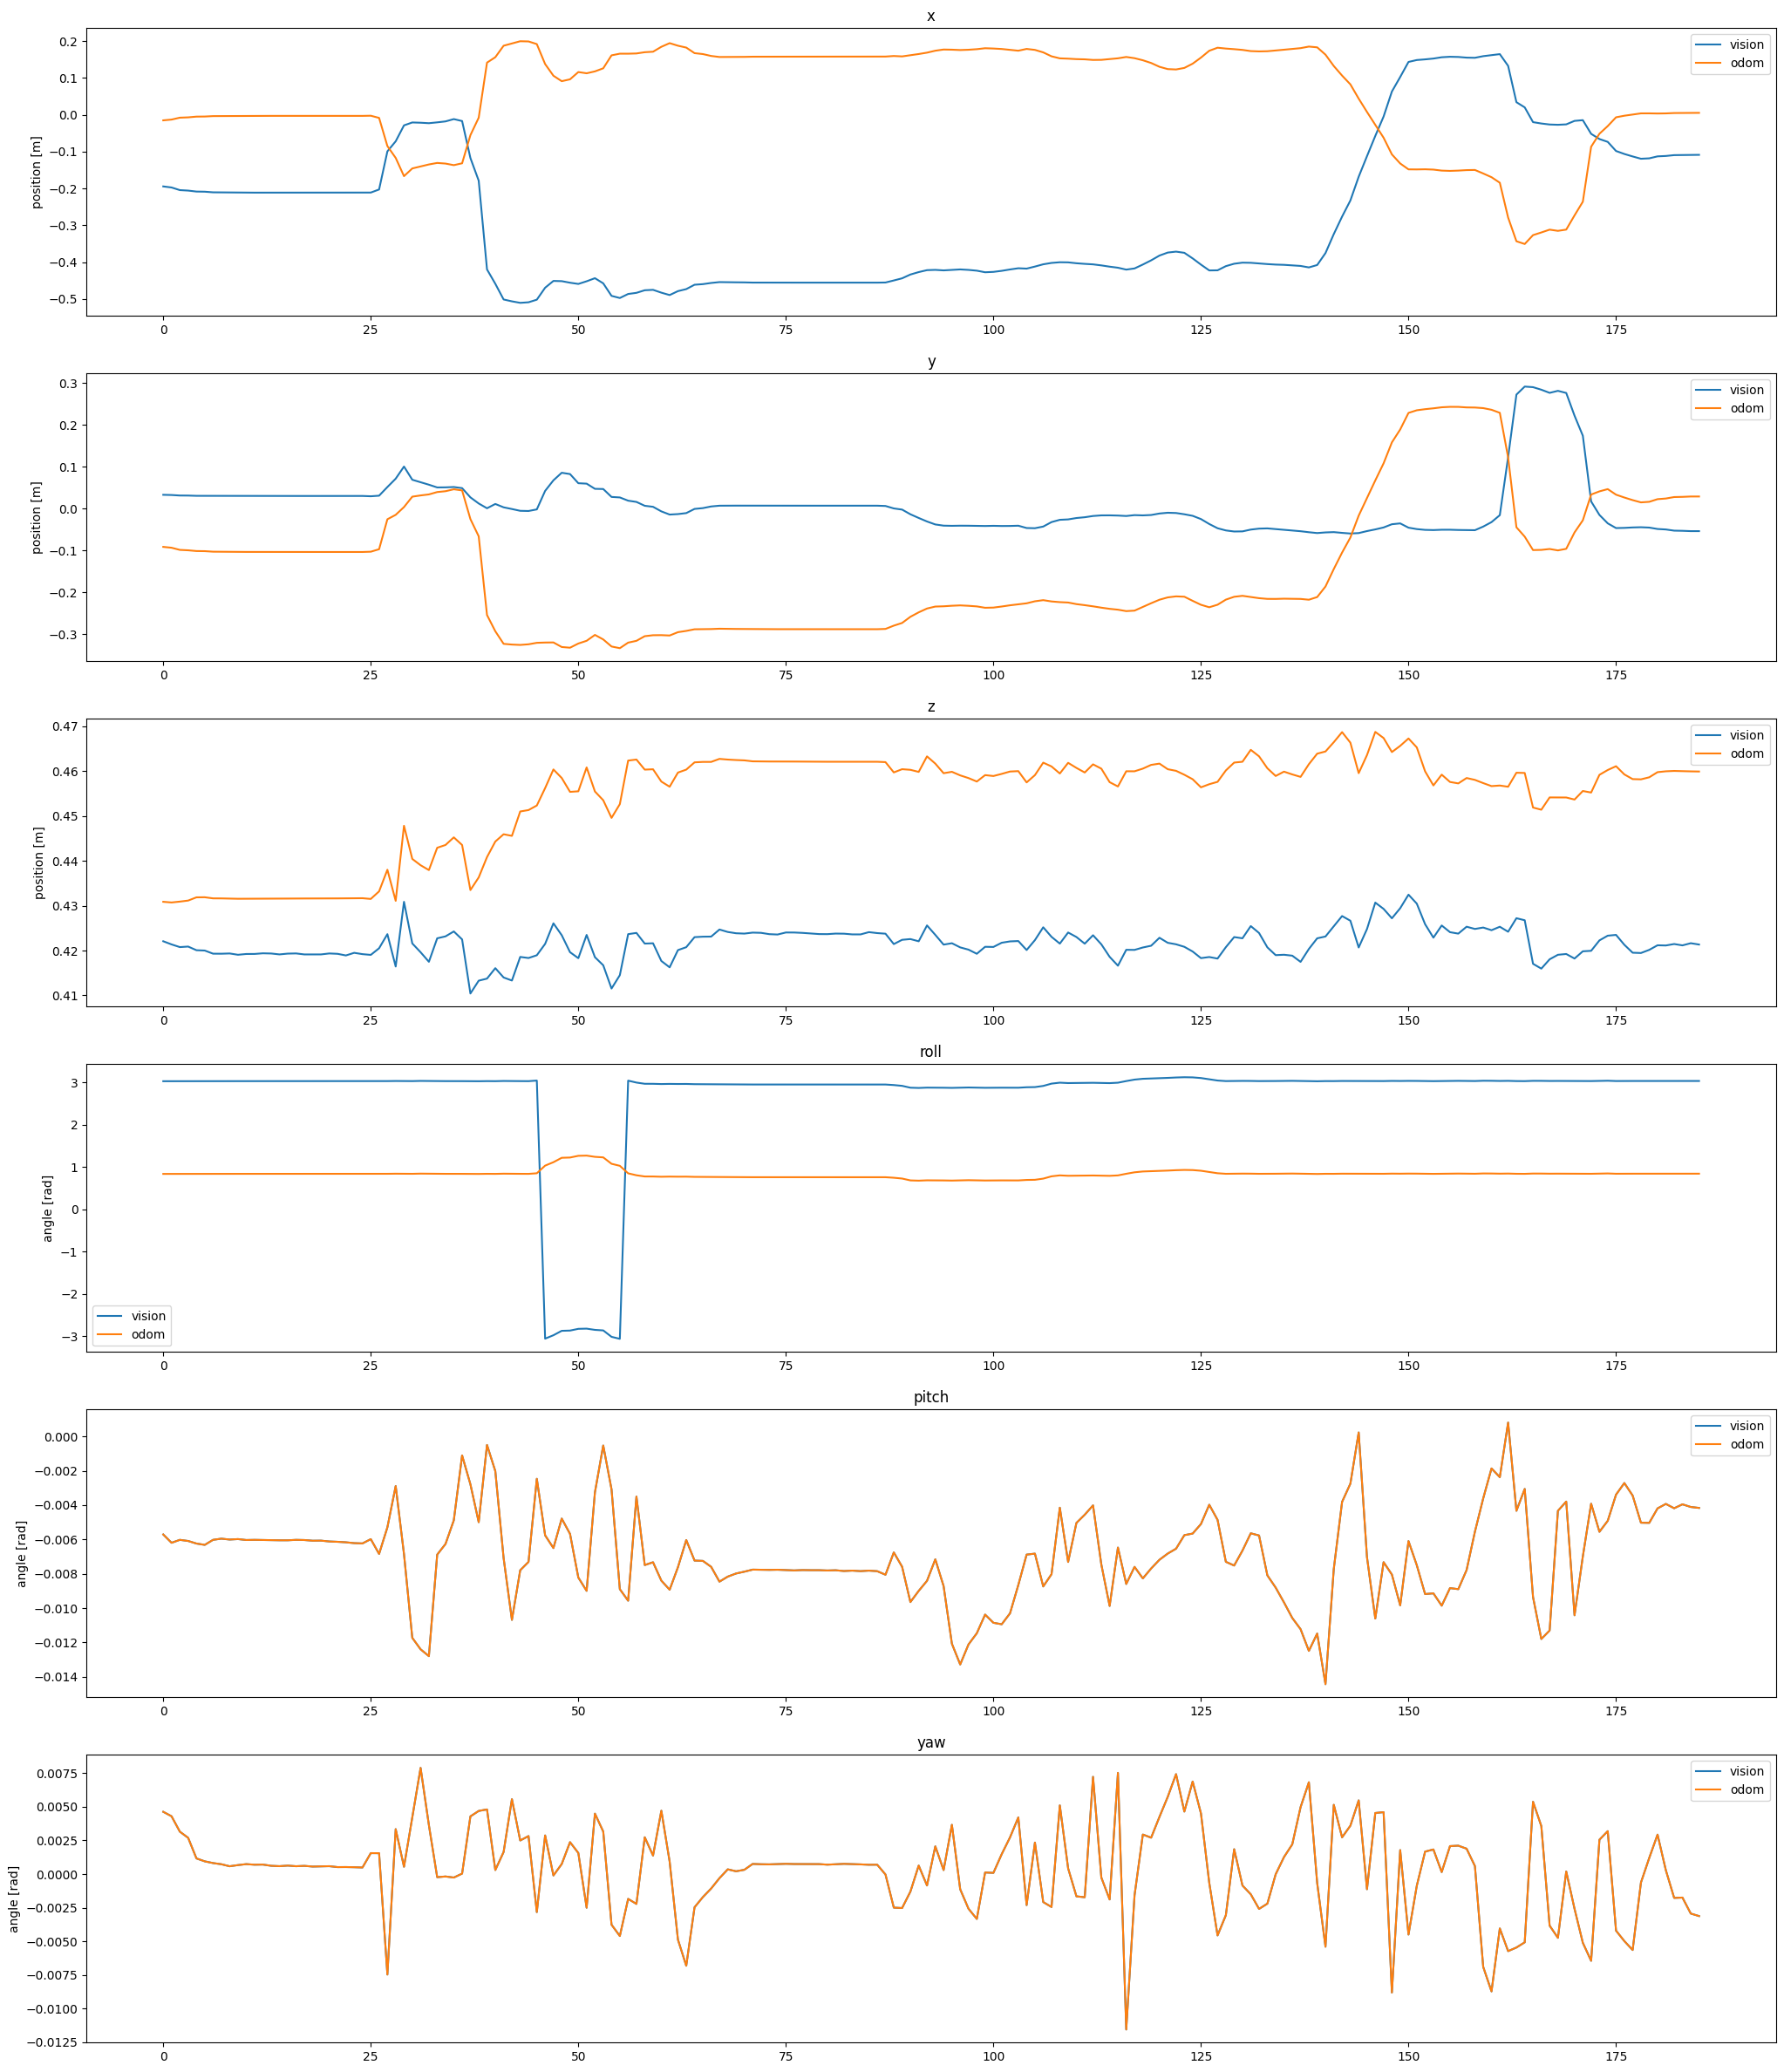

In [7]:
# plot body states from vision and odom

# parse data
vision_states = [s.next_state.pose_of_body_in_vision for s in states]
odom_states = [s.next_state.pose_of_body_in_odom for s in states]
vision_states = np.array(vision_states)
odom_states = np.array(odom_states)

# convert quaternions to euler angles
def quat_to_euler(qx, qy, qz, qw, order='xyz'):
    quaternion = np.array([qw, qx, qy, qz])
    rotation = R.from_quat(quaternion)
    euler_angles = rotation.as_euler(order)
    return euler_angles
vision_states_euler = np.array([quat_to_euler(qx, qy, qz, qw) for qx, qy, qz, qw in vision_states[:, 3:]])
odom_states_euler = np.array([quat_to_euler(qx, qy, qz, qw) for qx, qy, qz, qw in odom_states[:, 3:]])

# plot
labels = ["x", "y", "z", "roll", "pitch", "yaw"]    
fig, axs = plt.subplots(6, 1, figsize=(25, 30))
for i in range(6):
    if i < 3:
        axs[i].plot(vision_states[:, i], label="vision")
        axs[i].plot(odom_states[:, i], label="odom")
        axs[i].set_ylabel("position [m]")
    else:
        axs[i].plot(vision_states_euler[:, i-3], label="vision")
        axs[i].plot(odom_states_euler[:, i-3], label="odom")
        axs[i].set_ylabel("angle [rad]")
    axs[i].set_title(labels[i])
    axs[i].legend()


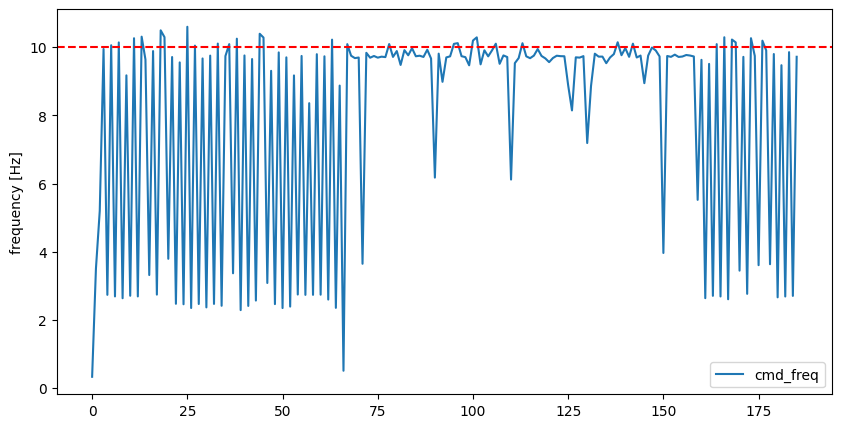

In [28]:
# plot delta_t of states

# parse data
delta_ts = [s.delta_t for s in states]
delta_ts = np.array(delta_ts)

# plot
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(1/-delta_ts, label="cmd_freq")
# plot line at 0.1=1/cmd_freq where cmd_freq=10Hz
axs.axhline(y=10, color='r', linestyle='--')
axs.set_ylabel("frequency [Hz]")
plt.legend()


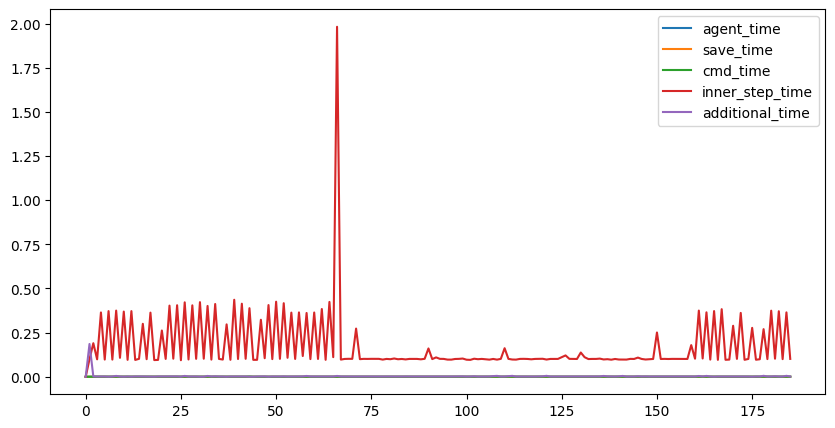

In [14]:
# plot time data

# parse data
time_data = data.data_buffers[0].times
agent_time = np.array([t.agent_time for t in time_data])
step_time = np.array([t.step_time for t in time_data])
save_time = np.array([t.save_time for t in time_data])
cmd_time = np.array([t.cmd_time for t in time_data])
inner_step_time = np.array([t.inner_step_time for t in time_data])
additional_time = np.array([t.additional_time for t in time_data])

# plot
fig = plt.figure(figsize=(10, 5))
plt.plot(agent_time, label="agent_time")
# plt.plot(step_time, label="step_time")
plt.plot(save_time, label="save_time")
plt.plot(cmd_time, label="cmd_time")
plt.plot(inner_step_time, label="inner_step_time")
plt.plot(additional_time, label="additional_time")
plt.legend()

plt.show()



In [15]:
# test command tracking for arm joint commands

# get arm joint commands
arm_joint_commands = [transition.cmd.commanded_arm_joint_positions for transition in transitions]
command_steps = [transition.step for transition in transitions]

# get arm joint states
arm_joint_states = [state.last_state.arm_joint_positions for state in states]
state_steps = [state.step for state in states]

# cut off at 150
arm_joint_commands = arm_joint_commands[:150]
command_steps = command_steps[:150]
arm_joint_states = arm_joint_states[:150]
state_steps = state_steps[:150]


# plot seperately in subplot for each joint (sh0, sh1, el0, el1, wr0, wr1)
fig, axs = plt.subplots(6, 1, figsize=(25, 20))
joint_names = ["sh0", "sh1", "el0", "el1", "wr0", "wr1"]
for i in range(6):
    axs[i].plot(command_steps, [np.rad2deg(command[i]) for command in arm_joint_commands], label="command")
    axs[i].plot(state_steps, [np.rad2deg(state[i]) for state in arm_joint_states], label="state")
    axs[i].set_title(joint_names[i])
    axs[i].legend()
    # set x and y labels
    if i == 5:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("angle [deg]")

plt.show()

AttributeError: 'NoneType' object has no attribute 'commanded_arm_joint_positions'

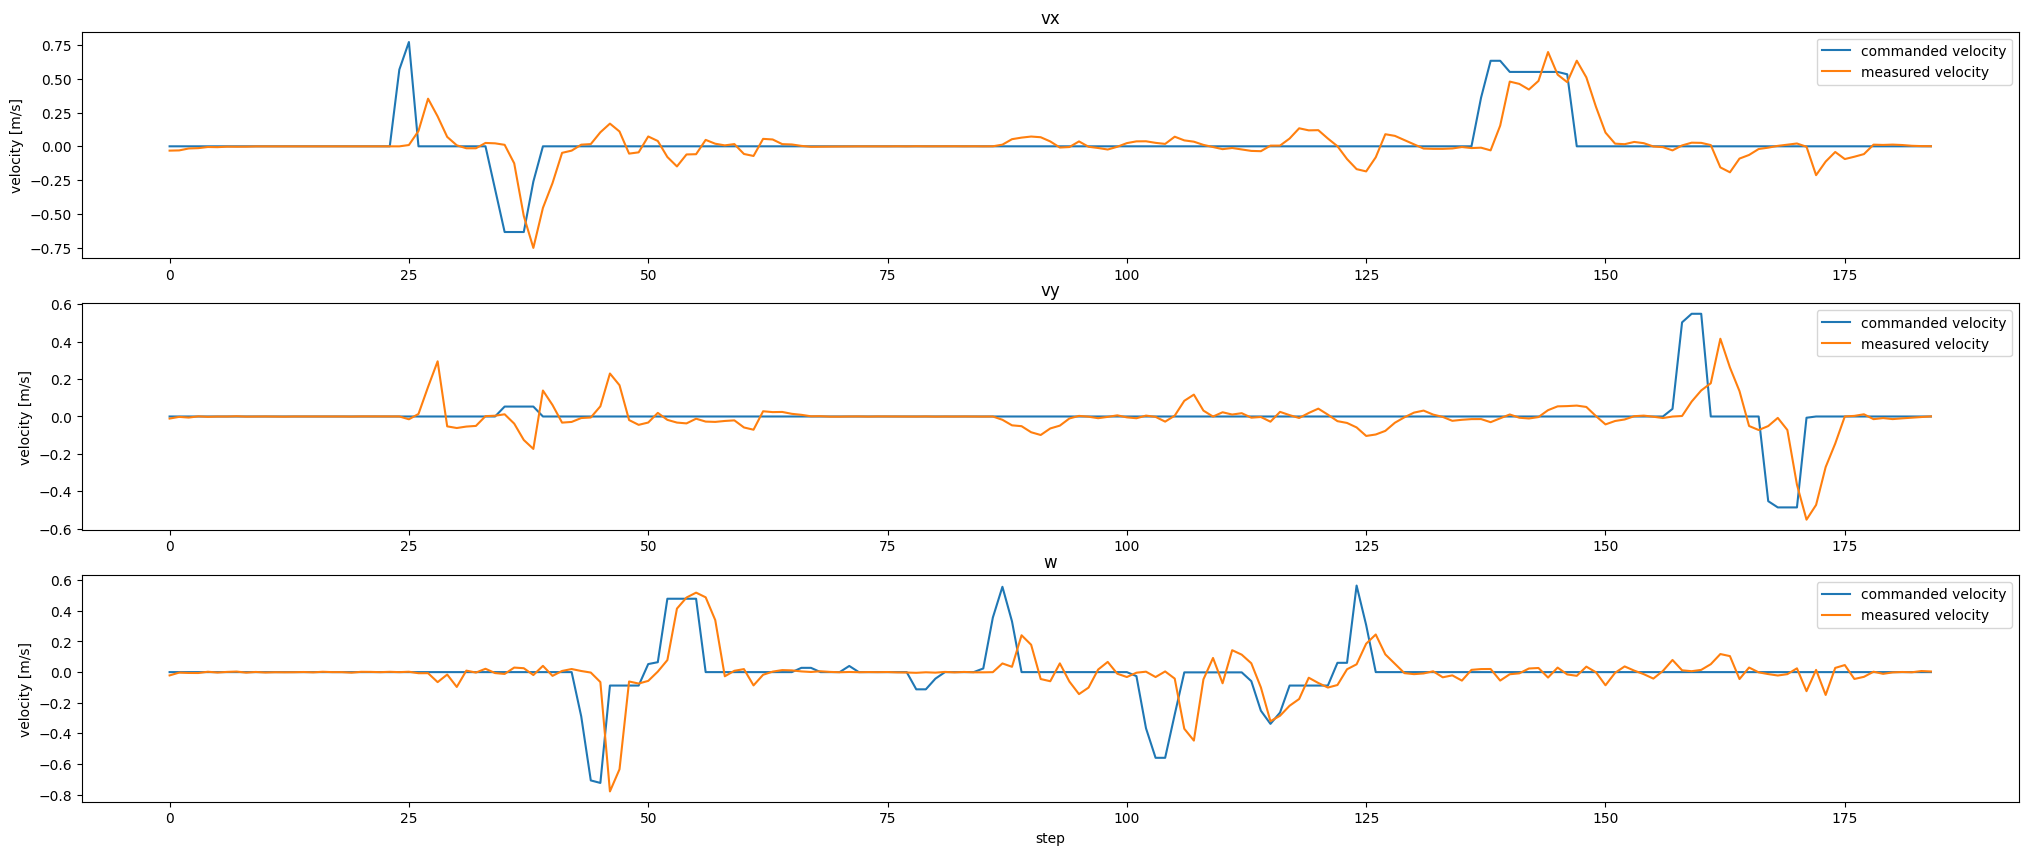

In [20]:
# test command tracking for body velocity commands

# load data
body_commands = [[transition.cmd.vx, transition.cmd.vy, transition.cmd.w] for transition in transitions if transition.cmd is not None]
body_velocity_states = [[state.last_state.velocity_of_body_in_vision[0], state.last_state.velocity_of_body_in_vision[1], state.last_state.velocity_of_body_in_vision[5]] for state in states if state.last_state is not None]

# plot
fig, axs = plt.subplots(3, 1, figsize=(25, 10))
body_names = ["vx", "vy", "w"]
for i in range(3):
    axs[i].plot([command[i] for command in body_commands], label="commanded velocity")
    axs[i].plot([state[i] for state in body_velocity_states], label="measured velocity")
    axs[i].set_title(body_names[i])
    axs[i].legend()
    if i == 2:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("velocity [m/s]")

plt.show()

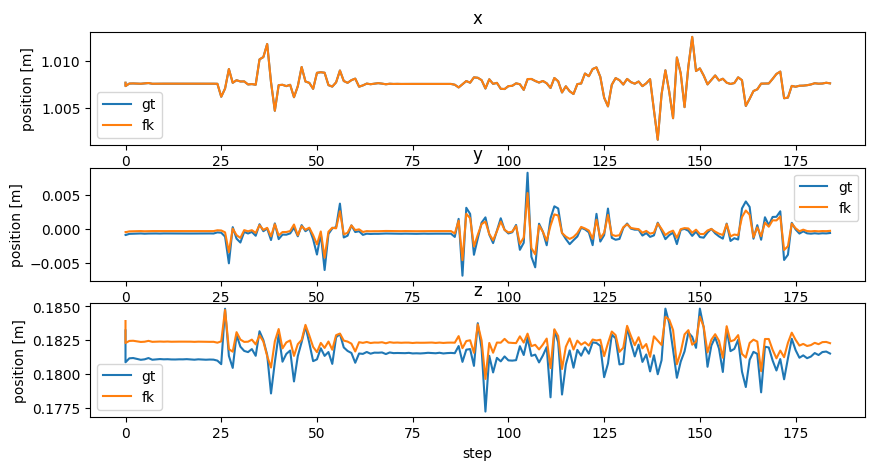

In [25]:
# test forward kinematics

from alrd.spot_gym.utils.spot_arm_fk import SpotArmFK

spot_arm_fk = SpotArmFK()

# get arm joint positions
arm_joint_positions = [state.next_state.arm_joint_positions for state in states]
state_steps = [state.step for state in states]

# get gt arm end effector positions
gt_ee_positions = [[state.next_state.pose_of_hand_in_body[0], state.next_state.pose_of_hand_in_body[1], state.next_state.pose_of_hand_in_body[2]] for state in states]

# get fk arm end effector positions
fk_ee_positions_cs = [spot_arm_fk.get_ee_position([arm_joint_position[0], arm_joint_position[1], arm_joint_position[2], arm_joint_position[3], arm_joint_position[4], arm_joint_position[5]]) for arm_joint_position in arm_joint_positions]
fk_ee_positions = np.array([dm.full().flatten() for dm in fk_ee_positions_cs])

# plot the fk and gt end effector positions
fig, axs = plt.subplots(3, 1, figsize=(10, 5))
ee_names = ["x", "y", "z"]
for i in range(3):
    axs[i].plot(state_steps, [gt_ee_position[i] for gt_ee_position in gt_ee_positions], label="gt")
    axs[i].plot(state_steps, [fk_ee_position[i] for fk_ee_position in fk_ee_positions], label="fk")
    axs[i].set_title(ee_names[i])
    axs[i].legend()
    # set x and y labels
    if i == 2:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("position [m]")

plt.show()

In [54]:
# test inverse kinematics

from alrd.spot_gym.utils.spot_arm_ik import SpotArmIK

spot_arm_ik = SpotArmIK()

# take only first 100 states 
states_new = states[:20]
state_steps = [state.step for state in states_new]

# get gt arm joint positions and gt end effector positions
gt_arm_joint_positions = [state.last_state.arm_joint_positions for state in states_new]
gt_ee_positions = [[state.last_state.pose_of_hand[0], state.last_state.pose_of_hand[1], state.last_state.pose_of_hand[2]] for state in states_new]

# get target end effector positions
target_ee_positions = gt_ee_positions[1:]
state_steps_shifted = state_steps[1:]

# get ik arm joint positions
ik_arm_joint_positions = [spot_arm_ik.calculate_ik(np.array(target_ee_position), np.array(current_arm_position)) for current_arm_position, target_ee_position in zip(gt_arm_joint_positions, target_ee_positions)]

In [56]:
fk_ee_positions = np.array([spot_arm_fk.get_ee_position(arm_joint_position) for arm_joint_position in ik_arm_joint_positions])

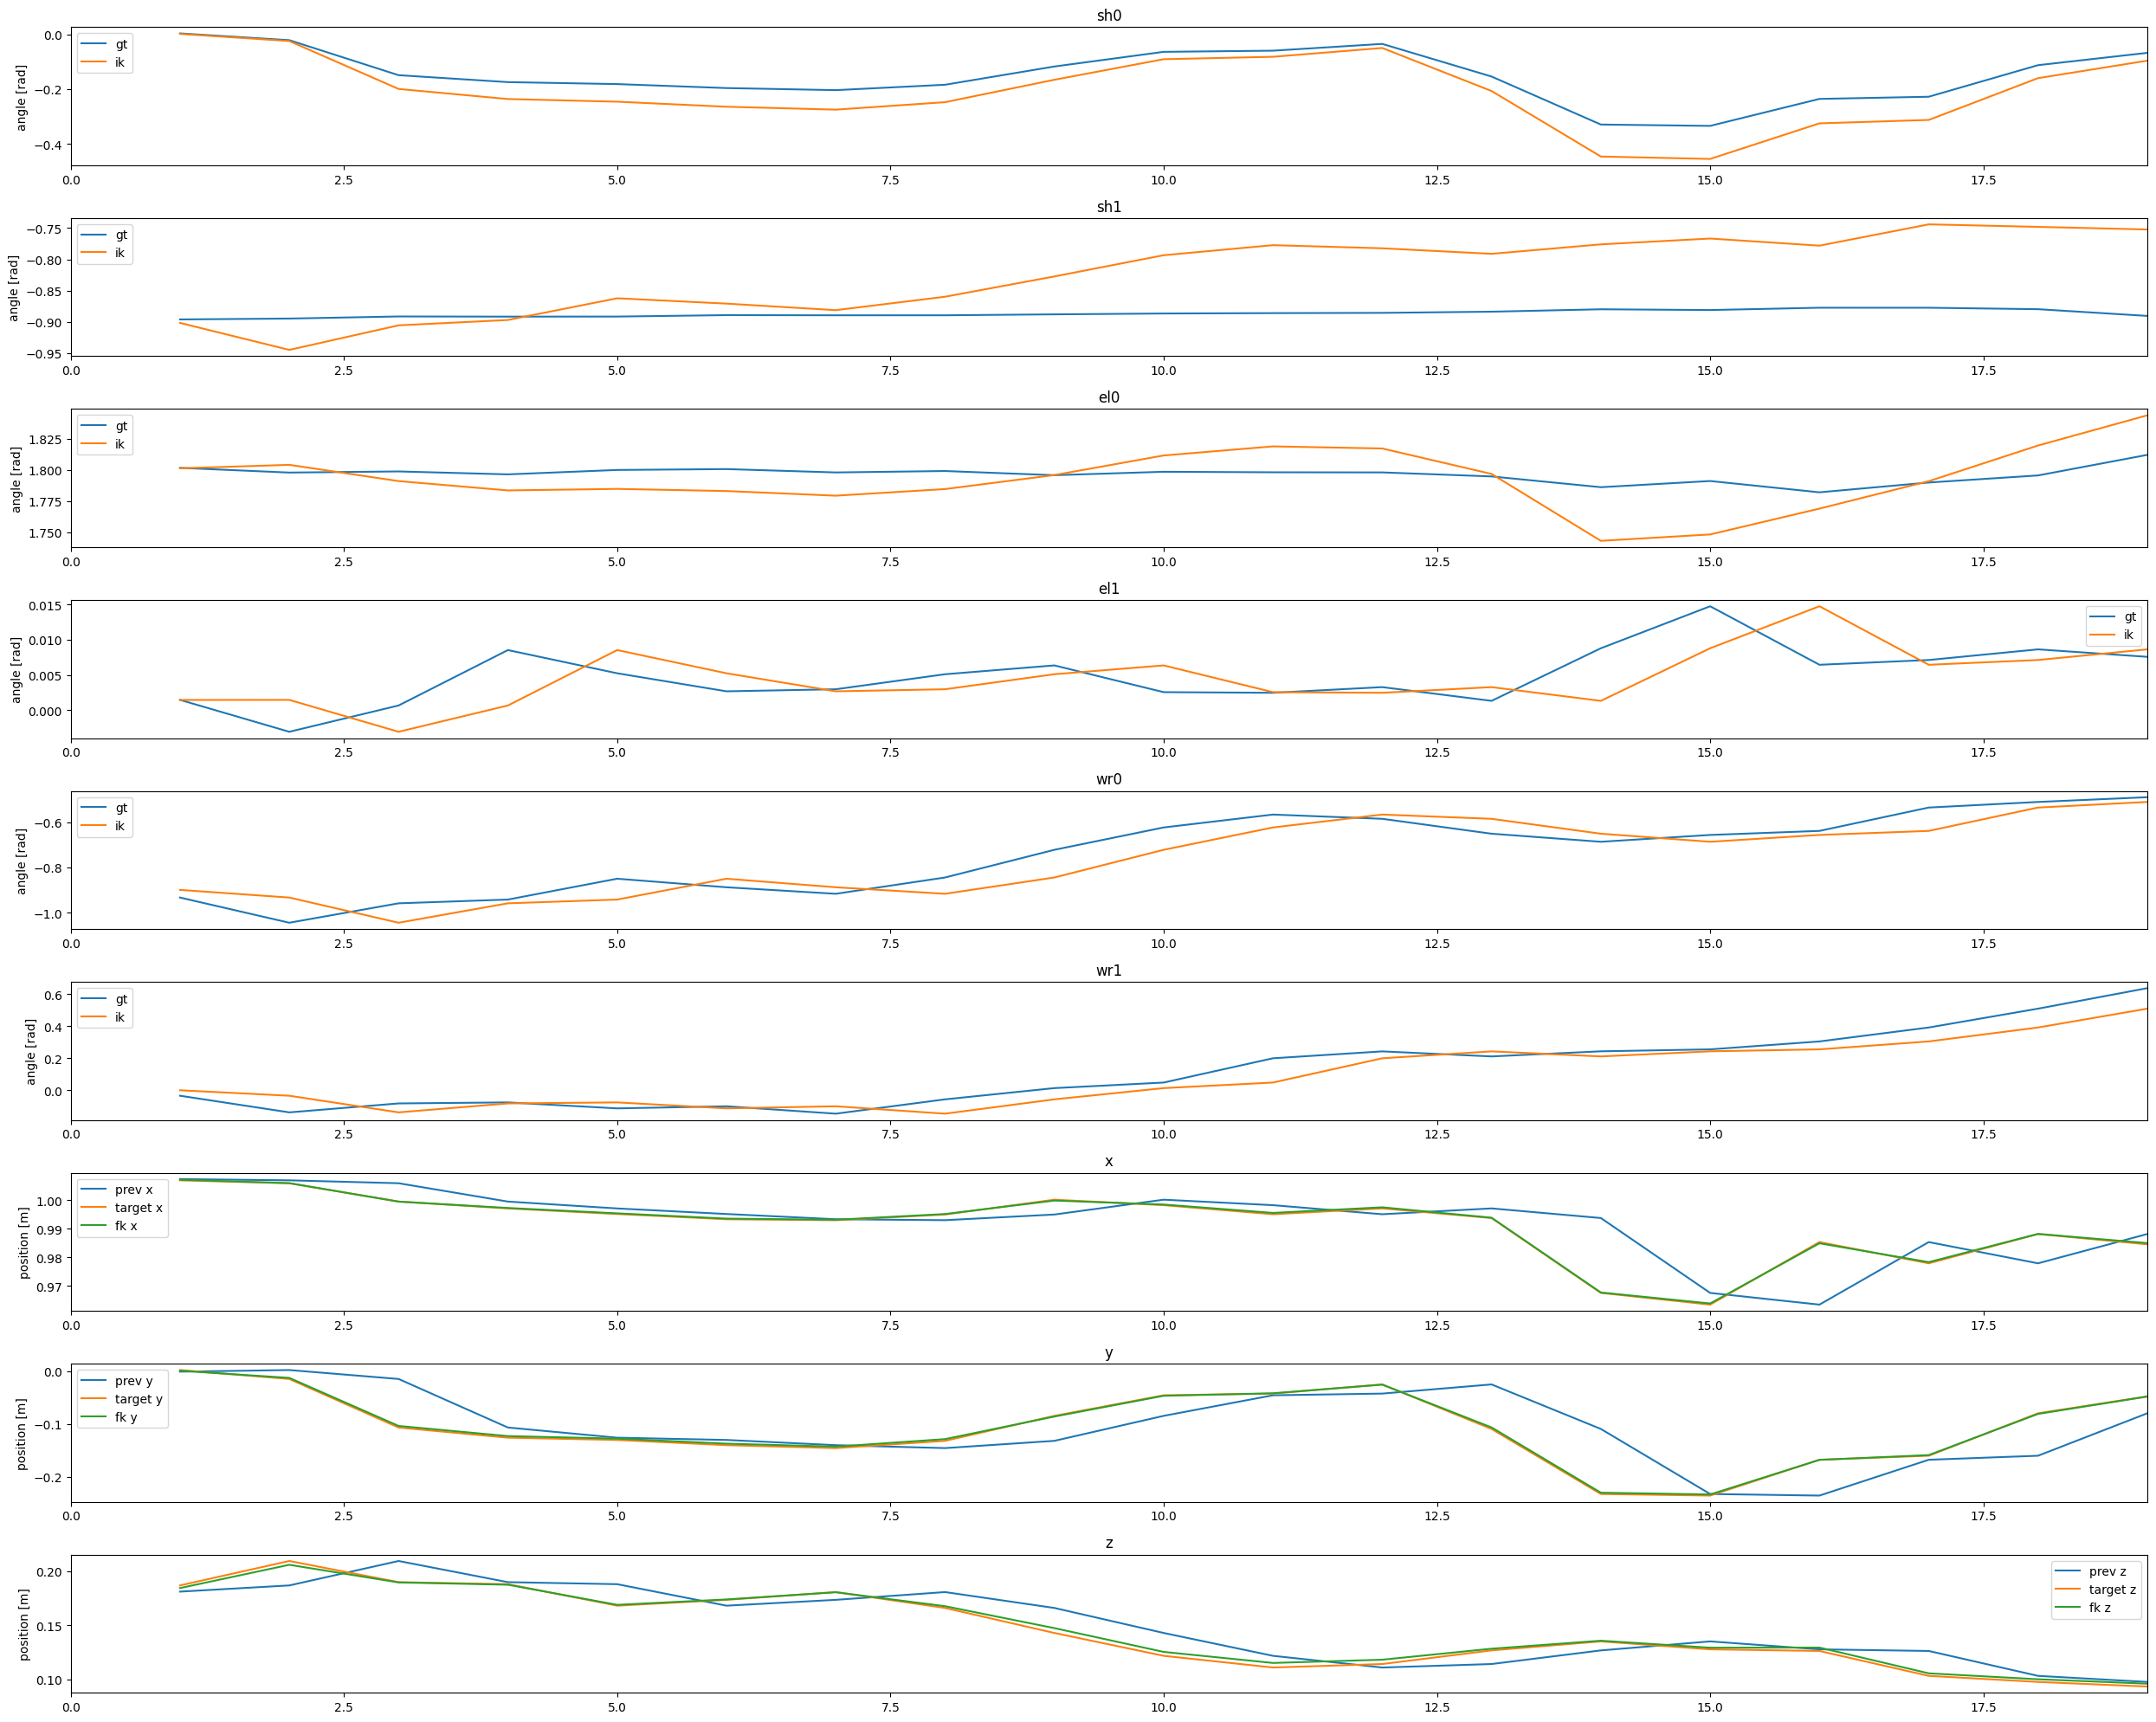

In [57]:
min_x_value = 0  # Assuming you want all x axes to start at zero
max_x_value = max(max(state_steps), max(state_steps_shifted))  # Find the max from all x data


# Create the subplots
fig, axs = plt.subplots(9, 1, figsize=(25, 20))
joint_names = ["sh0", "sh1", "el0", "el1", "wr0", "wr1"]

for i in range(6):
    axs[i].plot(state_steps[1:], [gt_arm_joint_position[i] for gt_arm_joint_position in gt_arm_joint_positions[1:]], label="gt")
    axs[i].plot(state_steps[1:], [ik_arm_joint_position[i] for ik_arm_joint_position in ik_arm_joint_positions], label="ik")
    axs[i].set_title(joint_names[i])
    axs[i].legend()
    axs[i].set_ylabel("angle [rad]")
    axs[i].set_xlim(min_x_value, max_x_value)  # Set the same x-axis scale for all plots

# Plot the target end effector positions
end_effector_labels = ['x', 'y', 'z']
for j in range(3):
    axs[6+j].plot(state_steps[1:], [gt_ee_position[j] for gt_ee_position in gt_ee_positions[:-1]], label="prev " + end_effector_labels[j])
    axs[6+j].plot(state_steps[1:], [target_ee_position[j] for target_ee_position in target_ee_positions], label="target " + end_effector_labels[j])
    axs[6+j].plot(state_steps[1:], [fk_ee_position[j] for fk_ee_position in fk_ee_positions], label="fk " + end_effector_labels[j])
    axs[6+j].set_title(end_effector_labels[j])
    axs[6+j].legend()
    axs[6+j].set_ylabel("position [m]")
    axs[6+j].set_xlim(min_x_value, max_x_value)  # Apply the same x-axis scale

plt.tight_layout()  # This will improve the spacing between plots to avoid overlap
plt.show()